<a href="https://colab.research.google.com/github/lorebianchi98/BrainTumorClassification/blob/main/2_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Brain Tumor Classification using VGG16
In this notebook we are going to perform the classification of the brain tumor using as base CNN VGG16.

# Import and Costants

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import models
from tensorflow.keras.models import Sequential
import numpy as np
import pandas as pd
from tensorflow import keras
import os
import shutil
import matplotlib.pyplot as plt
from tqdm import tqdm
from google.colab import drive
from tensorflow.keras.applications import VGG16

# Connection to Google Drive

In [ ]:
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
% run /content/gdrive/MyDrive/BrainTumorClassifier/utilities.ipynb

We also perform the download and the unzipping of the dataset from the drive folder.

In [ ]:
!unzip -q '/content/gdrive/MyDrive/BrainTumorClassifier/brain-tumor-mri-splits.zip' -d '/'

# Hardware Accelerator test

First we need to check if the hardware accelaration is enabled, since training a CNN on a CPU could be infeasible.

In [ ]:
#check hardware acceleration
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Dataset loading

Now we need to create the Dataset objects from the sets directory. We use the [image_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory) function provided by Keras. 

In [ ]:
train_ds, val_ds, test_ds = load_data_splits(IMAGE_SIZE, BATCH_SIZE)

Found 4213 files belonging to 4 classes.
Found 1404 files belonging to 4 classes.
Found 1406 files belonging to 4 classes.


# 256 Dense Neurons
Initially we are going to train a Multilayer Perceptron Network to classify brain tumor having as input the features extracted by VGG16. The last layer of VGG16 is removed, since it was a MLP Network built to classify ImageNet Dataset. The VGG16 layers are freezed in this part of training. 

In [ ]:
base_cnn = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(224,224,3)
)

base_cnn.trainable = False
base_cnn.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
inputs = keras.Input(shape=(224,224,3))
x = data_augmentation_layers(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = base_cnn(x)

x = layers.GlobalAveragePooling2D(name='gap')(x)
x = layers.Flatten(name='flatten')(x)
x = layers.Dense(256,activation='relu', name='classifier_hidden')(x)
output = layers.Dense(len(CLASSES), activation='softmax')(x)

model = tf.keras.models.Model(inputs=inputs, outputs=output, name="VGG16")

model = compile_model(model, loss="sparse_categorical_crossentropy")
model.summary()

Model: "VGG16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_8   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_8 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 gap (GlobalAveragePooling2D  (None, 512)              0     

Epoch 1/50
66/66 [==============================] - ETA: 0s - loss: 0.9020 - accuracy: 0.7273
Epoch 1: val_loss improved from inf to 0.50165, saving model to model/VGG16.h5
66/66 [==============================] - 55s 610ms/step - loss: 0.9020 - accuracy: 0.7273 - val_loss: 0.5017 - val_accuracy: 0.8177
Epoch 2/50
66/66 [==============================] - ETA: 0s - loss: 0.3038 - accuracy: 0.8911
Epoch 2: val_loss improved from 0.50165 to 0.33706, saving model to model/VGG16.h5
66/66 [==============================] - 31s 469ms/step - loss: 0.3038 - accuracy: 0.8911 - val_loss: 0.3371 - val_accuracy: 0.8789
Epoch 3/50
66/66 [==============================] - ETA: 0s - loss: 0.2161 - accuracy: 0.9221
Epoch 3: val_loss improved from 0.33706 to 0.29042, saving model to model/VGG16.h5
66/66 [==============================] - 31s 465ms/step - loss: 0.2161 - accuracy: 0.9221 - val_loss: 0.2904 - val_accuracy: 0.8946
Epoch 4/50
66/66 [==============================] - ETA: 0s - loss: 0.1570 - 

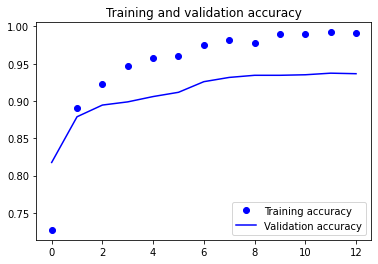

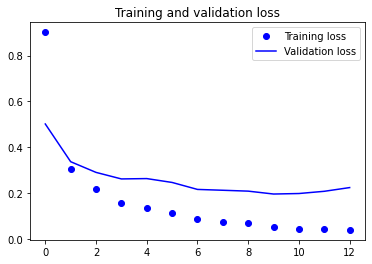

In [ ]:
model, history = run_model(model, model.name, train_ds, val_ds, 50, patience=3, monitor='val_loss')
plot_accuracy_and_loss_history(history)

In [ ]:
evaluate_model(model, test_ds)

22/22 [==============================] - 27s 540ms/step - loss: 0.2270 - accuracy: 0.9260
Loss on test set: 0.22699448466300964
Accuracy on test set: 0.9260312914848328
              precision    recall  f1-score   support

      glioma     0.8832    0.9077    0.8953       325
  meningioma     0.8742    0.8450    0.8594       329
     notumor     0.9752    0.9850    0.9801       400
   pituitary     0.9571    0.9517    0.9544       352

    accuracy                         0.9260      1406
   macro avg     0.9225    0.9223    0.9223      1406
weighted avg     0.9258    0.9260    0.9258      1406



22/22 [==============================] - 25s 522ms/step


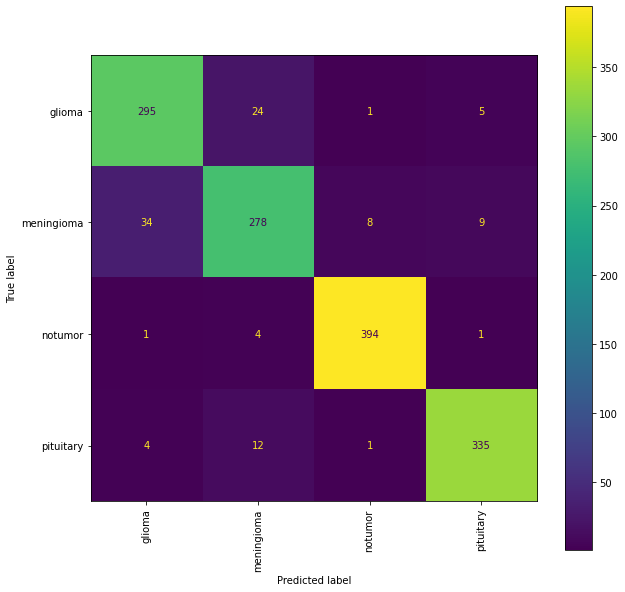

In [ ]:
plot_confusionmatrix(model, test_ds)

# 256 Dense Neurons, Dropout
Since the last model gave us accuracy on training set really close to 100% and on test set 92.6%, we have an high degree of overfitting. We try to add a Dropout layer with 0.3 rate to improve the capability of generalization of the model.

In [ ]:
inputs = keras.Input(shape=(224,224,3))
x = data_augmentation_layers(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = base_cnn(x)

x = layers.GlobalAveragePooling2D(name='gap')(x)
x = layers.Flatten(name='flatten')(x)
x = layers.Dense(256,activation='relu', name='classifier_hidden')(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(len(CLASSES), activation='softmax')(x)

model = tf.keras.models.Model(inputs=inputs, outputs=output, name="VGG16_Dropout")

model = compile_model(model, loss="sparse_categorical_crossentropy")
model.summary()

Model: "VGG16_Dropout"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_1   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 gap (GlobalAveragePooling2D  (None, 512)            

Epoch 1/50
66/66 [==============================] - ETA: 0s - loss: 1.7811 - accuracy: 0.6167
Epoch 1: val_loss improved from inf to 0.52340, saving model to model/VGG16_Dropout.h5
66/66 [==============================] - 41s 596ms/step - loss: 1.7811 - accuracy: 0.6167 - val_loss: 0.5234 - val_accuracy: 0.7963
Epoch 2/50
66/66 [==============================] - ETA: 0s - loss: 0.6086 - accuracy: 0.7823
Epoch 2: val_loss improved from 0.52340 to 0.38206, saving model to model/VGG16_Dropout.h5
66/66 [==============================] - 31s 465ms/step - loss: 0.6086 - accuracy: 0.7823 - val_loss: 0.3821 - val_accuracy: 0.8625
Epoch 3/50
66/66 [==============================] - ETA: 0s - loss: 0.4775 - accuracy: 0.8206
Epoch 3: val_loss improved from 0.38206 to 0.32439, saving model to model/VGG16_Dropout.h5
66/66 [==============================] - 30s 456ms/step - loss: 0.4775 - accuracy: 0.8206 - val_loss: 0.3244 - val_accuracy: 0.8860
Epoch 4/50
66/66 [==============================] - E

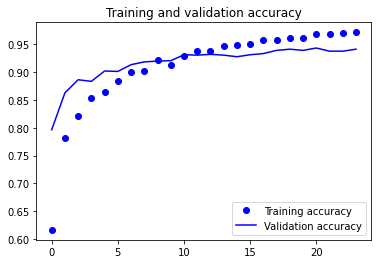

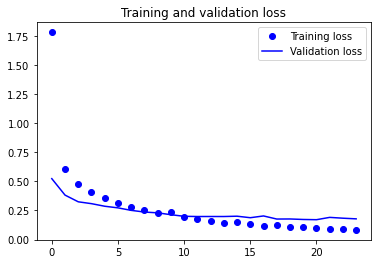

In [ ]:
model, history = run_model(model, model.name, train_ds, val_ds, 50, patience=3, monitor='val_loss')
plot_accuracy_and_loss_history(history)

In [ ]:
evaluate_model(model, test_ds)

22/22 [==============================] - 8s 340ms/step - loss: 0.1916 - accuracy: 0.9381
Loss on test set: 0.19155490398406982
Accuracy on test set: 0.9381223320960999
              precision    recall  f1-score   support

      glioma     0.9288    0.9231    0.9259       325
  meningioma     0.8728    0.8967    0.8846       329
     notumor     0.9750    0.9750    0.9750       400
   pituitary     0.9681    0.9489    0.9584       352

    accuracy                         0.9381      1406
   macro avg     0.9362    0.9359    0.9360      1406
weighted avg     0.9387    0.9381    0.9383      1406



22/22 [==============================] - 6s 303ms/step


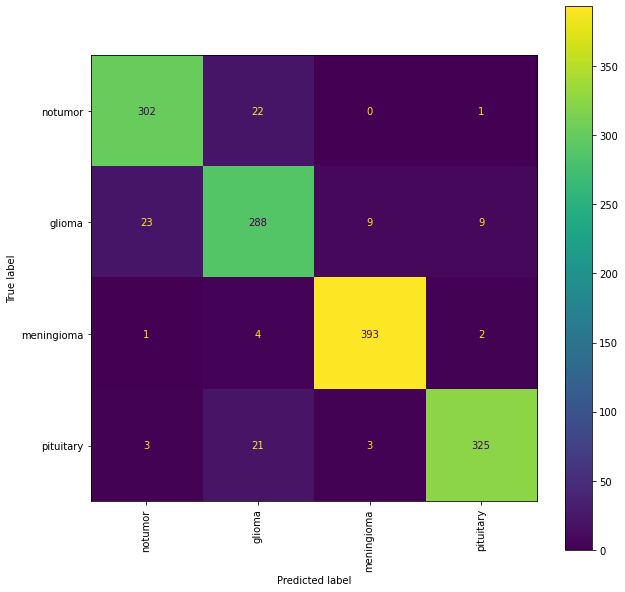

In [ ]:
plot_confusionmatrix(model, test_ds)

# 512 Dense Neurons, Dropout

In [ ]:
inputs = keras.Input(shape=(224,224,3))
x = data_augmentation_layers(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = base_cnn(x)

x = layers.GlobalAveragePooling2D(name='gap')(x)
x = layers.Flatten(name='flatten')(x)
x = layers.Dense(512,activation='relu', name='classifier_hidden')(x)
x = layers.Dropout(0.3)(x)
output = layers.Dense(len(CLASSES), activation='softmax')(x)

model = tf.keras.models.Model(inputs=inputs, outputs=output, name="VGG16_Dropout03_512Dense")

model = compile_model(model, loss="sparse_categorical_crossentropy")
model.summary()


Model: "VGG16_Dropout03_512Dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_3   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_3 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 gap (GlobalAveragePooling2D  (None, 512) 

Epoch 1/50
66/66 [==============================] - ETA: 0s - loss: 0.9972 - accuracy: 0.7187
Epoch 1: val_loss improved from inf to 0.37628, saving model to model/VGG16_Dropout03_512Dense.h5
66/66 [==============================] - 32s 461ms/step - loss: 0.9972 - accuracy: 0.7187 - val_loss: 0.3763 - val_accuracy: 0.8661
Epoch 2/50
66/66 [==============================] - ETA: 0s - loss: 0.4314 - accuracy: 0.8531
Epoch 2: val_loss improved from 0.37628 to 0.29986, saving model to model/VGG16_Dropout03_512Dense.h5
66/66 [==============================] - 31s 470ms/step - loss: 0.4314 - accuracy: 0.8531 - val_loss: 0.2999 - val_accuracy: 0.8882
Epoch 3/50
66/66 [==============================] - ETA: 0s - loss: 0.2993 - accuracy: 0.8880
Epoch 3: val_loss improved from 0.29986 to 0.26209, saving model to model/VGG16_Dropout03_512Dense.h5
66/66 [==============================] - 31s 462ms/step - loss: 0.2993 - accuracy: 0.8880 - val_loss: 0.2621 - val_accuracy: 0.9060
Epoch 4/50
66/66 [==

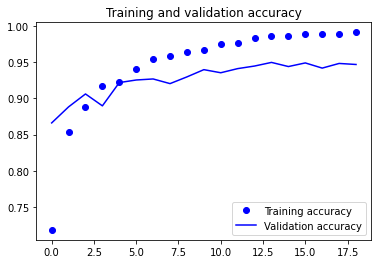

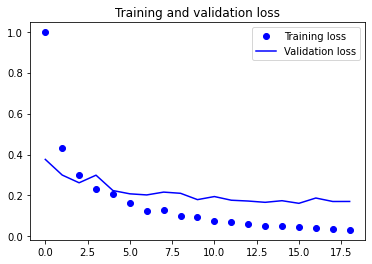

In [ ]:
model, history = run_model(model, model.name, train_ds, val_ds, 50, patience=3, monitor='val_loss')
plot_accuracy_and_loss_history(history)

In [ ]:
model = models.load_model(MODELS_PATH + "/VGG16_Dropout03_512Dense/VGG16_Dropout03_512Dense.h5")

In [ ]:
evaluate_model(model, test_ds)

22/22 [==============================] - 8s 351ms/step - loss: 0.1865 - accuracy: 0.9445
Loss on test set: 0.18647176027297974
Accuracy on test set: 0.9445234537124634
              precision    recall  f1-score   support

      glioma     0.9137    0.9446    0.9289       325
  meningioma     0.9012    0.8875    0.8943       329
     notumor     0.9800    0.9825    0.9813       400
   pituitary     0.9739    0.9545    0.9641       352

    accuracy                         0.9445      1406
   macro avg     0.9422    0.9423    0.9422      1406
weighted avg     0.9447    0.9445    0.9445      1406



22/22 [==============================] - 7s 332ms/step


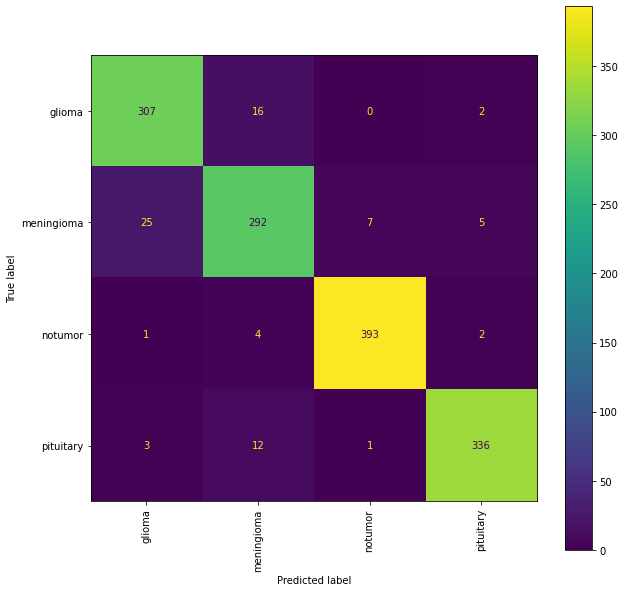

In [ ]:
plot_confusionmatrix(model, test_ds)

# Fine Tuning
Now it is time to unfreeze the last block of VGG16 to fine tune its weigths on our dataset. We choose the last model done, with Dropout and a dense layer of 512 Neurons as hidden classifier, since it is the configuration which achieved the better performance.

## Unfreezing last layer

In [ ]:
model = models.load_model('/content/gdrive/MyDrive/BrainTumorClassifier/Models/VGG16_Dropout03_512Dense/VGG16_Dropout03_512Dense.h5')

In [ ]:
model.summary()

Model: "VGG16_Dropout03_512Dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_3   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_3 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 gap (GlobalAveragePooling2D  (None, 512) 

In [ ]:
trainable = False
for layer in model.get_layer("vgg16").layers:
    if layer.name == 'block5_conv3':
        trainable = True
    layer.trainable = trainable

model = compile_model(model, loss="sparse_categorical_crossentropy")
model.summary()

Model: "VGG16_Dropout03_512Dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_3   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_3 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 gap (GlobalAveragePooling2D  (None, 512) 

Epoch 1/50
66/66 [==============================] - ETA: 0s - loss: 1.7125 - accuracy: 0.7835
Epoch 1: val_loss improved from inf to 0.28163, saving model to model/VGG16_LastLayerFineTuned.h5
66/66 [==============================] - 88s 1s/step - loss: 1.7125 - accuracy: 0.7835 - val_loss: 0.2816 - val_accuracy: 0.8981
Epoch 2/50
66/66 [==============================] - ETA: 0s - loss: 0.1640 - accuracy: 0.9392
Epoch 2: val_loss improved from 0.28163 to 0.17928, saving model to model/VGG16_LastLayerFineTuned.h5
66/66 [==============================] - 29s 432ms/step - loss: 0.1640 - accuracy: 0.9392 - val_loss: 0.1793 - val_accuracy: 0.9409
Epoch 3/50
66/66 [==============================] - ETA: 0s - loss: 0.1011 - accuracy: 0.9639
Epoch 3: val_loss did not improve from 0.17928
66/66 [==============================] - 29s 434ms/step - loss: 0.1011 - accuracy: 0.9639 - val_loss: 0.2020 - val_accuracy: 0.9288
Epoch 4/50
66/66 [==============================] - ETA: 0s - loss: 0.0863 - a

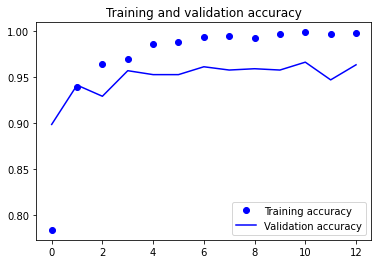

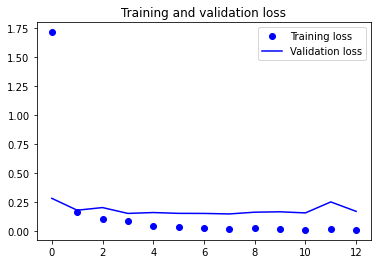

In [ ]:
model, history = run_model(model, "VGG16_LastLayerFineTuned", train_ds, val_ds, 50, patience=5, monitor='val_loss')
plot_accuracy_and_loss_history(history)

In [ ]:
model = models.load_model(MODELS_PATH + "/VGG16_LastLayerFineTuned/VGG16_LastLayerFineTuned.h5")

In [ ]:
evaluate_model(model, test_ds)

22/22 [==============================] - 8s 357ms/step - loss: 0.1837 - accuracy: 0.9531
Loss on test set: 0.18366014957427979
Accuracy on test set: 0.9530583024024963
              precision    recall  f1-score   support

      glioma     0.9288    0.9631    0.9456       325
  meningioma     0.9474    0.8754    0.9100       329
     notumor     0.9850    0.9875    0.9863       400
   pituitary     0.9451    0.9773    0.9609       352

    accuracy                         0.9531      1406
   macro avg     0.9516    0.9508    0.9507      1406
weighted avg     0.9532    0.9531    0.9527      1406



22/22 [==============================] - 7s 320ms/step


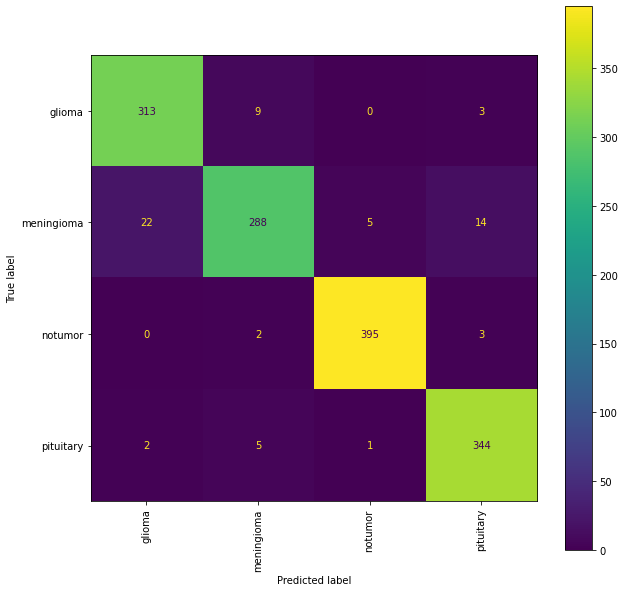

In [ ]:
plot_confusionmatrix(model, test_ds)

## Unfreezing last 2 layers
We will try to unfreeze also the second last layer, but instead of loading the model with the whole VGG16 block frozen, we will use the last model, applying a progressively finetuning of the second last layer having the weights of the last layer already finetuned.

In [ ]:
model = models.load_model('/content/gdrive/MyDrive/BrainTumorClassifier/Models/VGG16_LastLayerFineTuned/VGG16_LastLayerFineTuned.h5')

In [ ]:
model.summary()

Model: "VGG16_Dropout03_512Dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_3   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_3 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 gap (GlobalAveragePooling2D  (None, 512) 

In [ ]:
trainable = False
for layer in model.get_layer("vgg16").layers:
    if layer.name == 'block5_conv2':
        trainable = True
    layer.trainable = trainable

model = compile_model(model, loss="sparse_categorical_crossentropy")
model.summary()

Model: "VGG16_Dropout03_512Dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_3   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_3 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 gap (GlobalAveragePooling2D  (None, 512) 

Epoch 1/50
66/66 [==============================] - ETA: 0s - loss: 2.2320 - accuracy: 0.6513
Epoch 1: val_loss improved from inf to 0.53067, saving model to model/VGG16_Last2LayersFineTuned.h5
66/66 [==============================] - 31s 453ms/step - loss: 2.2320 - accuracy: 0.6513 - val_loss: 0.5307 - val_accuracy: 0.8091
Epoch 2/50
66/66 [==============================] - ETA: 0s - loss: 0.4253 - accuracy: 0.8391
Epoch 2: val_loss improved from 0.53067 to 0.43962, saving model to model/VGG16_Last2LayersFineTuned.h5
66/66 [==============================] - 30s 454ms/step - loss: 0.4253 - accuracy: 0.8391 - val_loss: 0.4396 - val_accuracy: 0.8497
Epoch 3/50
66/66 [==============================] - ETA: 0s - loss: 0.3623 - accuracy: 0.8721
Epoch 3: val_loss improved from 0.43962 to 0.34027, saving model to model/VGG16_Last2LayersFineTuned.h5
66/66 [==============================] - 31s 460ms/step - loss: 0.3623 - accuracy: 0.8721 - val_loss: 0.3403 - val_accuracy: 0.8775
Epoch 4/50
66/

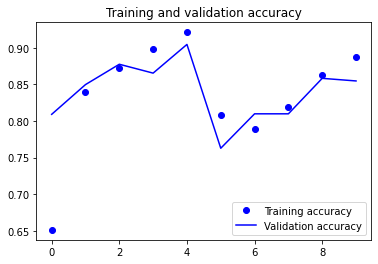

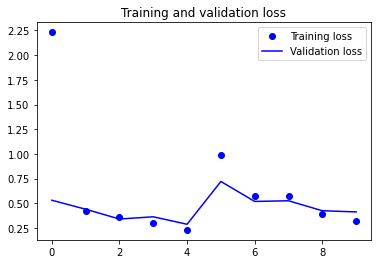

In [ ]:
model, history = run_model(model, "VGG16_Last2LayersFineTuned", train_ds, val_ds, 50, patience=5, monitor='val_loss')
plot_accuracy_and_loss_history(history)

We can observe from the training history a strange behaviour, the accuracy on both training and validation set dropped after the fifth epoch, leading the model to achieve very disappointing performances. We may suppose that our network get knocked into a bad part of parameter space corresponding to a sudden decrease in accuracy.

In general, lowering the learning rate is a good approach to this kind of problem.

In [ ]:
evaluate_model(model, test_ds)

22/22 [==============================] - 8s 331ms/step - loss: 0.2680 - accuracy: 0.9118
Loss on test set: 0.26795342564582825
Accuracy on test set: 0.9118065237998962
              precision    recall  f1-score   support

      glioma       0.94      0.87      0.90       325
  meningioma       0.84      0.82      0.83       329
     notumor       0.96      0.97      0.96       400
   pituitary       0.90      0.98      0.94       352

    accuracy                           0.91      1406
   macro avg       0.91      0.91      0.91      1406
weighted avg       0.91      0.91      0.91      1406



22/22 [==============================] - 7s 325ms/step


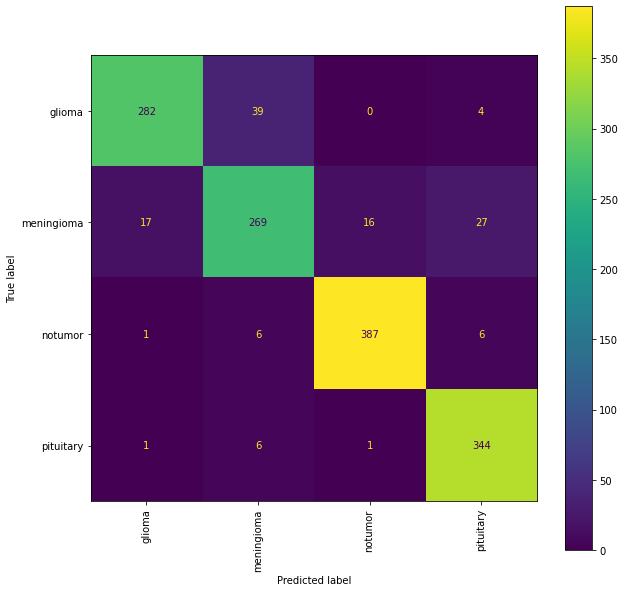

In [ ]:
plot_confusionmatrix(model, test_ds)

Now we reload the model and reperform the training with a lower learning rate

In [ ]:
model = models.load_model('/content/gdrive/MyDrive/BrainTumorClassifier/Models/VGG16_LastLayerFineTuned/VGG16_LastLayerFineTuned.h5')

In [ ]:
model.summary()

Model: "VGG16_Dropout03_512Dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_3   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_3 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 gap (GlobalAveragePooling2D  (None, 512) 

In [ ]:
trainable = False
for layer in model.get_layer("vgg16").layers:
    if layer.name == 'block5_conv2':
        trainable = True
    layer.trainable = trainable

model = compile_model(model, loss="sparse_categorical_crossentropy", learning_rate=0.0002)
model.summary()

Model: "VGG16_Dropout03_512Dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_3   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_3 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 gap (GlobalAveragePooling2D  (None, 512) 

Epoch 1/50
66/66 [==============================] - ETA: 0s - loss: 0.2965 - accuracy: 0.9119
Epoch 1: val_loss improved from inf to 0.23786, saving model to model/VGG16_Last2LayersFineTuned_ReducedLR.h5
66/66 [==============================] - 33s 277ms/step - loss: 0.2965 - accuracy: 0.9119 - val_loss: 0.2379 - val_accuracy: 0.9274
Epoch 2/50
66/66 [==============================] - ETA: 0s - loss: 0.0521 - accuracy: 0.9812
Epoch 2: val_loss improved from 0.23786 to 0.18500, saving model to model/VGG16_Last2LayersFineTuned_ReducedLR.h5
66/66 [==============================] - 16s 241ms/step - loss: 0.0521 - accuracy: 0.9812 - val_loss: 0.1850 - val_accuracy: 0.9566
Epoch 3/50
66/66 [==============================] - ETA: 0s - loss: 0.0410 - accuracy: 0.9843
Epoch 3: val_loss improved from 0.18500 to 0.15971, saving model to model/VGG16_Last2LayersFineTuned_ReducedLR.h5
66/66 [==============================] - 16s 241ms/step - loss: 0.0410 - accuracy: 0.9843 - val_loss: 0.1597 - val_a

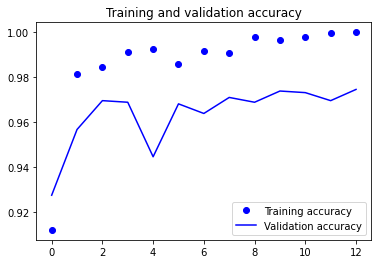

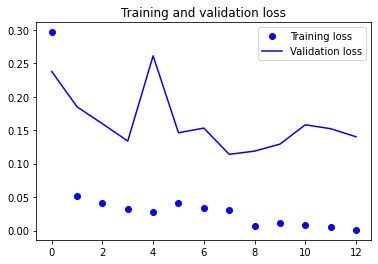

In [ ]:
model, history = run_model(model, "VGG16_Last2LayersFineTuned_ReducedLR", train_ds, val_ds, 50, patience=5, monitor='val_loss')
plot_accuracy_and_loss_history(history)

In [ ]:
evaluate_model(model, test_ds)

22/22 [==============================] - 5s 228ms/step - loss: 0.1479 - accuracy: 0.9659
Loss on test set: 0.14785729348659515
Accuracy on test set: 0.9658606052398682
              precision    recall  f1-score   support

      glioma     0.9552    0.9846    0.9697       325
  meningioma     0.9450    0.9392    0.9421       329
     notumor     0.9923    0.9725    0.9823       400
   pituitary     0.9659    0.9659    0.9659       352

    accuracy                         0.9659      1406
   macro avg     0.9646    0.9656    0.9650      1406
weighted avg     0.9661    0.9659    0.9659      1406



22/22 [==============================] - 3s 160ms/step


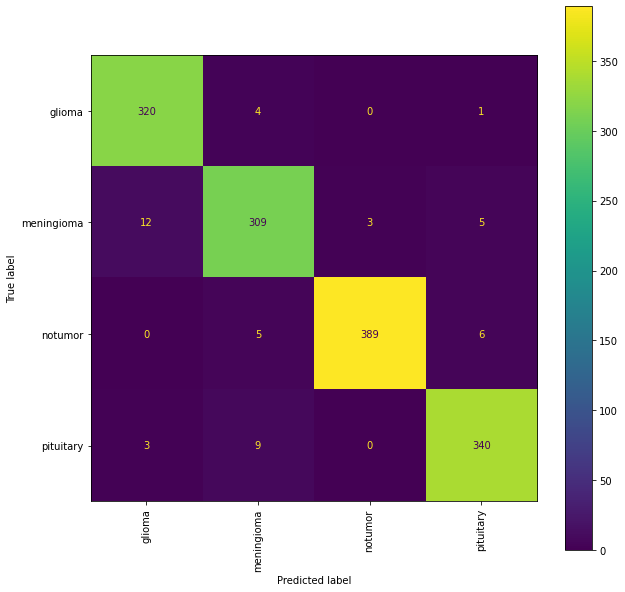

In [ ]:
plot_confusionmatrix(model, test_ds)

## Unfreezing the whole last block
Starting from the last model trained we finally unfreeze the whole last block

In [ ]:
model = models.load_model('/content/gdrive/MyDrive/BrainTumorClassifier/Models/VGG16_Last2LayersFineTuned_ReducedLR/VGG16_Last2LayersFineTuned_ReducedLR.h5')

In [ ]:
model.summary()

Model: "VGG16_Dropout03_512Dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_3   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_3 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 gap (GlobalAveragePooling2D  (None, 512) 

In [ ]:
trainable = False
for layer in model.get_layer("vgg16").layers:
    if layer.name == 'block5_conv1':
        trainable = True
    layer.trainable = trainable

model = compile_model(model, loss="sparse_categorical_crossentropy",learning_rate=0.0002)
model.summary()

Model: "VGG16_Dropout03_512Dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_3   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_3 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 gap (GlobalAveragePooling2D  (None, 512) 

Epoch 1/50
66/66 [==============================] - ETA: 0s - loss: 0.4999 - accuracy: 0.8690
Epoch 1: val_loss improved from inf to 0.25940, saving model to model/VGG16_LastBlockFineTuned.h5
66/66 [==============================] - 19s 265ms/step - loss: 0.4999 - accuracy: 0.8690 - val_loss: 0.2594 - val_accuracy: 0.9288
Epoch 2/50
66/66 [==============================] - ETA: 0s - loss: 0.1364 - accuracy: 0.9528
Epoch 2: val_loss improved from 0.25940 to 0.16939, saving model to model/VGG16_LastBlockFineTuned.h5
66/66 [==============================] - 17s 251ms/step - loss: 0.1364 - accuracy: 0.9528 - val_loss: 0.1694 - val_accuracy: 0.9501
Epoch 3/50
66/66 [==============================] - ETA: 0s - loss: 0.0734 - accuracy: 0.9722
Epoch 3: val_loss improved from 0.16939 to 0.16566, saving model to model/VGG16_LastBlockFineTuned.h5
66/66 [==============================] - 17s 250ms/step - loss: 0.0734 - accuracy: 0.9722 - val_loss: 0.1657 - val_accuracy: 0.9580
Epoch 4/50
66/66 [==

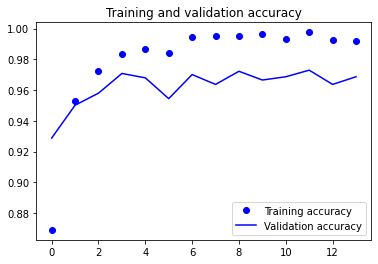

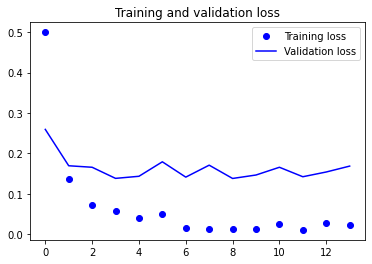

In [ ]:
model, history = run_model(model, "VGG16_LastBlockFineTuned", train_ds, val_ds, 50, patience=5, monitor='val_loss')
plot_accuracy_and_loss_history(history)

In [ ]:
model = models.load_model(MODELS_PATH + "//.h5")

In [ ]:
evaluate_model(model, test_ds)

22/22 [==============================] - 4s 167ms/step - loss: 0.1687 - accuracy: 0.9680
Loss on test set: 0.16874152421951294
Accuracy on test set: 0.9679943323135376
              precision    recall  f1-score   support

      glioma     0.9664    0.9723    0.9693       325
  meningioma     0.9371    0.9514    0.9442       329
     notumor     0.9899    0.9800    0.9849       400
   pituitary     0.9742    0.9659    0.9700       352

    accuracy                         0.9680      1406
   macro avg     0.9669    0.9674    0.9671      1406
weighted avg     0.9682    0.9680    0.9681      1406



22/22 [==============================] - 3s 161ms/step


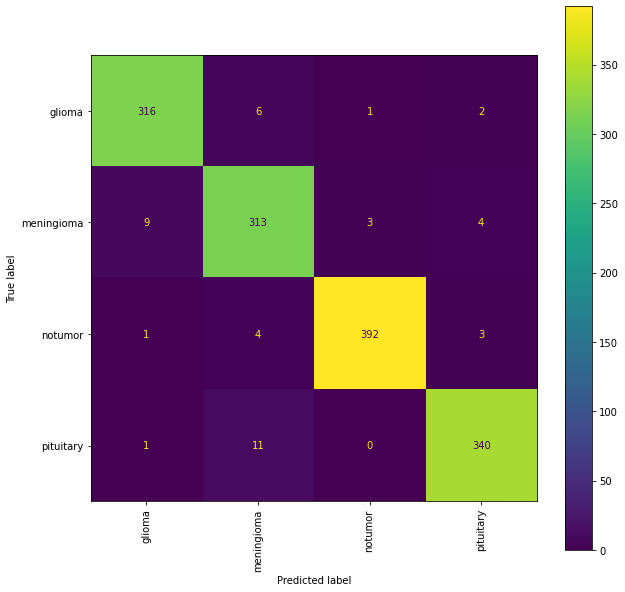

In [ ]:
plot_confusionmatrix(model, test_ds)

### Unfreezing the last block not progressively
We try now to perform a step different from the one done before. We try to unfreeze completely the last block and perform the finetuning, trying to compare the performances with the model unfreezed progressively.

In [ ]:
model = models.load_model(MODELS_PATH + '/VGG16_Dropout03_512Dense/VGG16_Dropout03_512Dense.h5')

In [ ]:
model.summary()

Model: "VGG16_Dropout03_512Dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_3   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_3 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 gap (GlobalAveragePooling2D  (None, 512) 

In [ ]:
trainable = False
for layer in model.get_layer("vgg16").layers:
    if layer.name == 'block5_conv1':
        trainable = True
    layer.trainable = trainable

model = compile_model(model, loss="sparse_categorical_crossentropy",learning_rate = 0.0002)
model.summary()

Model: "VGG16_Dropout03_512Dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_3   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_3 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 gap (GlobalAveragePooling2D  (None, 512) 

Epoch 1/50
66/66 [==============================] - ETA: 0s - loss: 1.4627 - accuracy: 0.5540
Epoch 1: val_loss improved from inf to 0.51641, saving model to model/VGG16_LastBlockFineTunedEntirely.h5
66/66 [==============================] - 41s 604ms/step - loss: 1.4627 - accuracy: 0.5540 - val_loss: 0.5164 - val_accuracy: 0.7977
Epoch 2/50
66/66 [==============================] - ETA: 0s - loss: 0.4572 - accuracy: 0.8343
Epoch 2: val_loss improved from 0.51641 to 0.35033, saving model to model/VGG16_LastBlockFineTunedEntirely.h5
66/66 [==============================] - 34s 518ms/step - loss: 0.4572 - accuracy: 0.8343 - val_loss: 0.3503 - val_accuracy: 0.8768
Epoch 3/50
66/66 [==============================] - ETA: 0s - loss: 0.3291 - accuracy: 0.8851
Epoch 3: val_loss did not improve from 0.35033
66/66 [==============================] - 35s 520ms/step - loss: 0.3291 - accuracy: 0.8851 - val_loss: 0.3625 - val_accuracy: 0.8789
Epoch 4/50
66/66 [==============================] - ETA: 0s

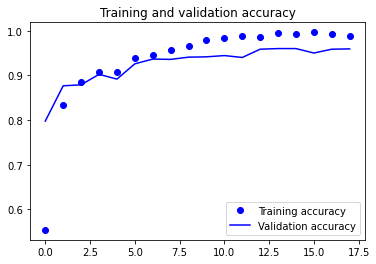

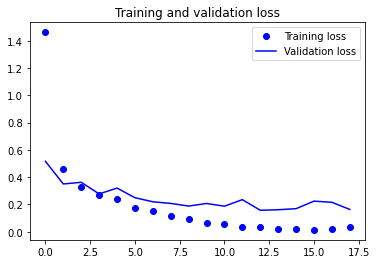

In [ ]:
model, history = run_model(model, "VGG16_LastBlockFineTunedEntirely", train_ds, val_ds, 50, patience=5, monitor='val_loss')
plot_accuracy_and_loss_history(history)

In [ ]:
evaluate_model(model, test_ds)

22/22 [==============================] - 8s 350ms/step - loss: 0.1371 - accuracy: 0.9580
Loss on test set: 0.13705043494701385
Accuracy on test set: 0.9580369591712952
              precision    recall  f1-score   support

      glioma     0.9619    0.9323    0.9469       325
  meningioma     0.9219    0.9331    0.9275       329
     notumor     0.9636    0.9925    0.9778       400
   pituitary     0.9827    0.9659    0.9742       352

    accuracy                         0.9580      1406
   macro avg     0.9575    0.9560    0.9566      1406
weighted avg     0.9582    0.9580    0.9580      1406



22/22 [==============================] - 7s 349ms/step


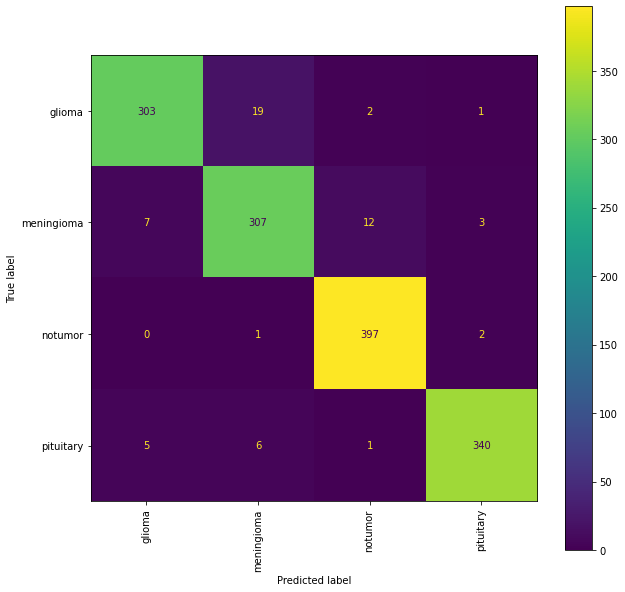

In [ ]:
plot_confusionmatrix(model, test_ds)